Compare multilevel perceptrons (MLPs) on the spiral classification problem, where data is generated from several clusters with varying spiral radii.

In [1]:
# Run to select GPU #1 and limit memory usage to 30%
# from armed.tfutils import set_gpu
# set_gpu(1, 0.3)

In [3]:
import os
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
from sklearn.model_selection import StratifiedKFold

from spirals import make_spiral_random_radius, make_spiral_random_radius_confounder, plot_clusters, make_spiral_true_boundary
from armed.models.mlp_classifiers import BaseMLP, ClusterCovariateMLP, DomainAdversarialMLP, MixedEffectsMLPNonlinearSlope
from armed.models.metalearning import mldg
from armed.misc import expand_results_path, make_random_onehot

sys.path.append("../../../menn")
from model.random_intercept_network import RandomInterceptNetwork
from utils.fe_models import get_model
from data.preprocessing import dataset_preprocessing


Define output directory path.

In [4]:
strOutputDir = expand_results_path('./spirals/random_radii/')
strOutputDir = './spirals/random_radii/'

In [5]:
strOutputDir

'./spirals/random_radii/'

Spiral generation parameters. 
* clusters: Number of clusters 
* false_negatives: True draws the random radii from a distribution centered at zero, such that half the clusters have flipped spirals. This increases problem difficulty by obscuring the predictiveness of the features. False centers the distribution at 1. 
* confound_sd: If simulating confounded_vars, sets the strength of the confounding factor.
* radius_sd: Inter-cluster variance of random radii
* degrees: Spiral arclength in degrees
* confounded_vars: Number of confounded variables to add
* noise: s.d. of added Gaussian noise
* random_seed

In [6]:
dictSpiralParams = {'clusters': 10, 
                    'false_negatives': False, 
                    'confound_sd': 0.,
                    'radius_sd': 0.3,
                    'degrees': 360,
                    'confounded_vars': 0,
                    'noise': 0.1,
                    'random_seed': 48}

Create and visualize dataset

C:\Users\AndrejTschalzev\AppData\Local\Temp\ipykernel_14872\1300008413.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figData.show()


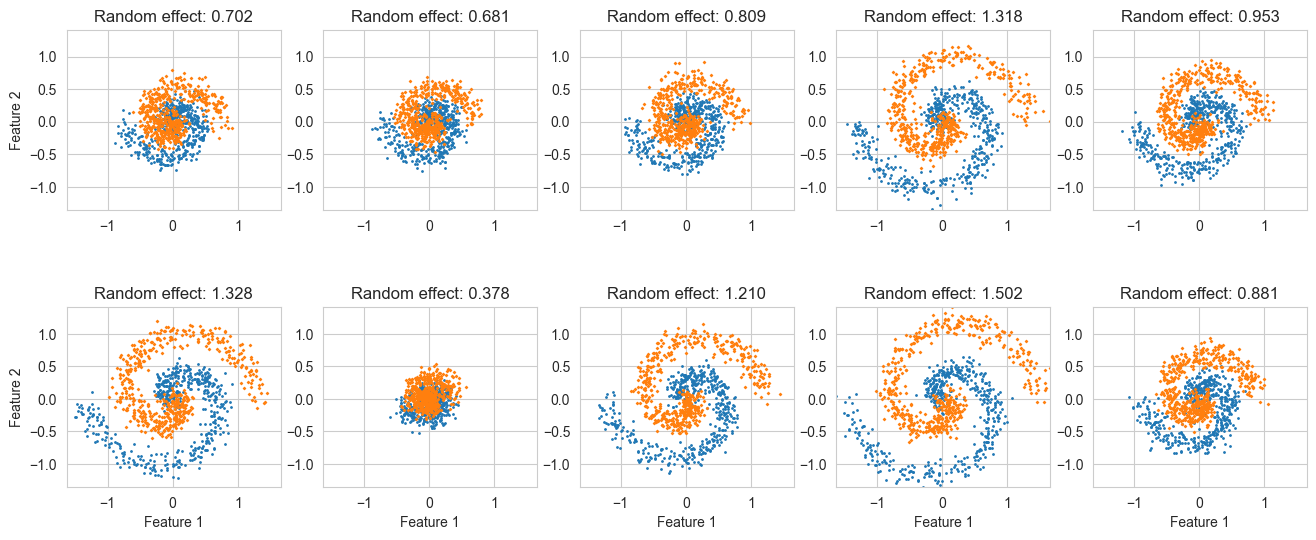

In [7]:
# Create dataset
np.random.seed(dictSpiralParams['random_seed'])
if dictSpiralParams['confound_sd'] > 0:
    arrX, arrZ, arrY, arrRadii, arrRatio = make_spiral_random_radius_confounder(dictSpiralParams['clusters'],
                                                                                mean_radius=0 if dictSpiralParams['false_negatives'] else 1,
                                                                                ratio_sd=dictSpiralParams['confound_sd'],
                                                                                radius_sd=dictSpiralParams['radius_sd'],
                                                                                degrees=dictSpiralParams['degrees'],
                                                                                confounders=dictSpiralParams['confounded_vars'],
                                                                                noise=dictSpiralParams['noise'])
else:    
    arrX, arrZ, arrY, arrRadii = make_spiral_random_radius(dictSpiralParams['clusters'], 
                                                        mean_radius=0 if dictSpiralParams['false_negatives'] else 1, 
                                                        inter_cluster_sd=dictSpiralParams['radius_sd'], 
                                                        degrees=dictSpiralParams['degrees'],
                                                        noise=dictSpiralParams['noise'])

figData, axData = plot_clusters(arrX, arrZ, arrY, arrRadii)
figData.savefig(os.path.join(strOutputDir, 'spirals_data.png'))
figData.savefig(os.path.join(strOutputDir, 'spirals_data.svg'))
figData.show()

# One-hot to binary labels
arrY = arrY[:, 1]

# Ensure float32
arrX = arrX.astype(np.float32)
arrY = arrY.astype(np.float32)
arrZ = arrZ.astype(np.float32)

# Use the class label and cluster membership in stratified k-fold partitioning later
arrStrata = [f'{y}_{z}' for y, z in zip(arrY, arrZ.argmax(axis=1))]
arrStrata = np.array(arrStrata)

In [8]:
# create informative names for the confounded probe features
lsFeatureNames = ['1', '2'] 
if dictSpiralParams['confounded_vars'] > 0:
    lsFeatureNames += [f'Probe {i+1}' for i in range(dictSpiralParams['confounded_vars'])]

In [9]:
def compute_grads(model, inputs):
    """Compute feature gradients/partial derivatives.

    Args:
        model: trained model
        inputs (array or tuple): model inputs

    Returns:
        pd.DataFrame: feature gradients
    """    

    if isinstance(inputs, tuple):
        x, z = inputs
        x = x.mean(axis=0).reshape((1, -1))
        # Use all zero design matrix, since for the ME-MLP we 
        # only want to measure the feature sensitivity of the 
        # fixed effects submodel.
        z = np.zeros((1, z.shape[1]), dtype=np.float32)
        
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            tz = tf.zeros_like(z)
            gt.watch(tx)
            gt.watch(tz)
            ty = model((tx, tz))
            
        dydx = gt.gradient(ty, tx)

    else:
        x = inputs
        x = x.mean(axis=0).reshape((1, -1))
        with tf.GradientTape() as gt:
            tx = tf.constant(x)
            gt.watch(tx)
            ty = model(tx)
            
        dydx = gt.gradient(ty, tx)

    dfGrads = pd.DataFrame(np.abs(dydx.numpy()), columns=lsFeatureNames)
    return pd.melt(dfGrads, var_name='Feature', value_name='Gradient')
    
def compute_random_slope_sd(model):
    """Compute the inter-cluster variances of the ME-MLP's learned random slopes.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: s.d. for each feature
    """    
    arrRandomSlopePosterior = model.randomeffects.re_slope.weights[0].numpy()
    nClusters = dictSpiralParams['clusters']
    nFeatures = 2 + dictSpiralParams['confounded_vars']
    nWeights = nClusters * nFeatures
    arrRandomSlope = arrRandomSlopePosterior[:nWeights]
    arrRandomSlope = arrRandomSlope.reshape((nClusters, nFeatures))

    return pd.DataFrame({'Feature': lsFeatureNames, 'S.D.': arrRandomSlope.std(axis=0)})
    
def get_random_intercepts(model):
    """Get the learned random intercepts from the trained ME-MLP.

    Args:
        model: trained model

    Returns:
        pd.DataFrame: Cluster-specific random intercepts
    """    
    arrRandomIntPosterior = model.randomeffects.re_int.weights[0].numpy()
    nClusters = dictSpiralParams['clusters']
    arrRandomInt = arrRandomIntPosterior[:nClusters]
    
    return pd.DataFrame({'Cluster': range(nClusters), 'Random intercept': arrRandomInt})


def plot_percluster_decision_boundary(model, X, Y, Z, cluster_input=False, vmax=1.5, degrees=360, radii=None):
    """Plot decision boundaries learned per cluster. Currently only works with 2-class problems.

    Args:
        model (tf.keras.Model): trained model
        X (np.array): input
        Y (np.array): target
        Z (np.array): cluster membership matrix
        cluster_input (bool, optional): Whether model takes a cluster membership input. Defaults to False.
        vmax (float, optional): Extent of feature space to plot. Defaults to 1.5.
        degrees (int, optional): Spiral length (to plot true decision boundary). Defaults to 360.
        radii (array, optional): Cluster-specific radii (to plot true decision boundary). Defaults to None.

    Returns:
        figure, axes
    """    
    
    nClusters = Z.shape[1]
    nAxRows = int(np.ceil(nClusters / 5))
    fig, axes = plt.subplots(nAxRows, 5, figsize=(16, 3 * nAxRows), gridspec_kw={'hspace': 0.5})
    
    for iCluster in range(nClusters):
        ax = axes.flatten()[iCluster]
        
        arrXCluster = X[Z[:, iCluster]==1,]
        arrYCluster = Y[Z[:, iCluster]==1,]
        arrZCluster = Z[Z[:, iCluster]==1,]
        
        # Create grid of points in feature space
        arrGridX1, arrGridX2 = np.mgrid[-vmax:vmax+0.1:0.01, -vmax:vmax+0.1:0.01]
        # Fill in extra confounded features with 0.5
        if X.shape[1] > 2:
            arrGridX3 = np.ones_like(arrGridX1) * 0.5
            arrGridXConf = np.stack([arrGridX3.flatten()] * (X.shape[1] - 2), axis=-1)
            arrGridX = np.concatenate([arrGridX1.reshape(-1, 1), arrGridX2.reshape(-1, 1), arrGridXConf], axis=1)
        else:    
            arrGridX = np.stack([arrGridX1.flatten(), arrGridX2.flatten()], axis=0).T
            
        if cluster_input:
            arrGridZ = np.zeros((arrGridX.shape[0], Z.shape[1]))
            arrGridZ[:, iCluster] = 1
            try:# model == RandomInterceptNetwork:
                arrGridYFlat = model.predict((arrGridX, arrGridZ), verbose=0)
            except:
                print("Manually added exception for GMENN occured")
                arrGridYFlat = model.predict(arrGridX, arrGridZ.astype(float)).numpy()
        else:
            try:
                arrGridYFlat = model.predict(arrGridX, verbose=0) 
            except:
                print("Manually added exception for GMENN occured")
                arrGridZ = np.zeros((arrGridX.shape[0], Z.shape[1]))
                arrGridZ[:, iCluster] = 1
                try:# model == RandomInterceptNetwork:
                    arrGridYFlat = model.predict((arrGridX, arrGridZ), verbose=0)
                except:
                    arrGridYFlat = model.predict(tf.cast(tf.convert_to_tensor(arrGridX),tf.float32), arrGridZ.astype(int)).numpy()
            
        
        if isinstance(arrGridYFlat, tuple):
            arrGridYFlat = arrGridYFlat[0]
        arrGridY = (arrGridYFlat >= 0.5).reshape(arrGridX1.shape).astype(int)
        
        # Use contour function to visualize decision boundary
        ax.contour(arrGridX1, arrGridX2, arrGridY, levels=1, colors='k')  
        ax.contourf(arrGridX1, arrGridX2, arrGridY, levels=1, colors=['C0', 'C1'], alpha=0.5)    
        
        # Plot data points
        ax.scatter(arrXCluster[arrYCluster == 0, 0], arrXCluster[arrYCluster == 0, 1], 
                   c='C0', s=5, alpha=0.9)
        ax.scatter(arrXCluster[arrYCluster == 1, 0], arrXCluster[arrYCluster == 1, 1], 
                   c='C1', s=10, alpha=0.9, marker='P')
        
        if radii is not None:
            # Plot true decision boundary (midpoint between classes)
            arrTrueBoundary = make_spiral_true_boundary(degrees=degrees-180, 
                                                        radius=radii[iCluster])
            ax.plot(arrTrueBoundary[:1000, 0], 
                                        arrTrueBoundary[:1000, 1], 
                                        c='g', ls='--', lw=3)   
            ax.plot(arrTrueBoundary[1000:, 0], 
                                        arrTrueBoundary[1000:, 1], 
                                        c='g', ls='--', lw=3)
                
        # Include accuracy in subplot title    
        try:
            if cluster_input:
                acc = model.evaluate((arrXCluster, arrZCluster), arrYCluster, verbose=0, return_dict=True)['acc']
            else:
                acc = model.evaluate(arrXCluster, arrYCluster, verbose=0, return_dict=True)['acc']
        except:
            print("Manually added exception for GMENN occured")
            acc = model.evaluate(["accuracy"], arrXCluster, arrYCluster, arrZCluster.astype(int))["accuracy"]

        ax.set_title(f'Accuracy: {acc:.03f}')
        
        ax.set_xlim(-vmax, vmax)
        ax.set_ylim(-vmax, vmax)
        ax.set_aspect('equal')    
    return fig, axes
    

def cross_validate(model_class, use_z=False, build_args={}, compile_args={}, use_mldg=False, randomize_z=False,epochs=10):
    """Perform 10-fold cross-validation and return per-fold performance, feature importance, and decision boundary plot.

    Args:
        model_class: model class
        use_z (bool, optional): Whether model takes Z input. Defaults to False.
        build_args (dict, optional): Model build arguments. Defaults to {}.
        compile_args (dict, optional): Model compile arguments. Defaults to {}.
        use_mldg (bool, optional): Whether to use meta-learning domain generalization to train. Defaults to False.
        randomize_z (bool, optional): Randomize the Z input when evaluating on test data 
            (ablating the RE information). Defaults to False.

    Returns:
        if model_class == MixedEffectsMLPNonlinearSlope:
            performance, feature importance, random slope variance, random intercepts, decision boundary fig
        else: 
        performance, feature importance, decision boundary fig
    """    
    kfolds = StratifiedKFold(10)
    lsResults = []
    lsGrads = []
    if model_class == MixedEffectsMLPNonlinearSlope:
        lsRandomSlopeSD = [] 
        lsRandomInt = []  
    
    for fold_num, (arrTrainIdx, arrTestIdx) in enumerate(kfolds.split(arrX, arrStrata)):
        if fold_num!=9:
            continue
        print(f"Training fold {fold_num}")
        arrXTrain = arrX[arrTrainIdx,]
        arrYTrain = arrY[arrTrainIdx,]
        arrZTrain = arrZ[arrTrainIdx,]
        arrXTest = arrX[arrTestIdx,]
        arrYTest = arrY[arrTestIdx,]
        arrZTest = arrZ[arrTestIdx,]
        
        tf.random.set_seed(283)
        
        if model_class==RandomInterceptNetwork:
            build_args_split = build_args.copy()
            build_args_split["fe_model"] = build_args_split["fe_model"]()
            model = model_class(**build_args_split)
        else:
            model = model_class(**build_args)

        if randomize_z:
            arrZTest = make_random_onehot(arrXTest.shape[0], arrZTrain.shape[1])
        
        if use_z:
            dataTrain = (arrXTrain, arrZTrain)
            dataTest = (arrXTest, arrZTest)
            # dataHeldout = (xHeldout, zHeldout)
        else:
            dataTrain = arrXTrain
            dataTest = arrXTest     
            # dataHeldout = xHeldout
            
        if model_class==RandomInterceptNetwork:
            
            arrZTrain_menn = np.argmax(arrZTrain,axis=1).reshape(-1,1)
            arrZTest_menn = np.argmax(arrZTest,axis=1).reshape(-1,1)
            
            config = compile_args
            e_mode = config["menn_parameters"]["e_mode"]
            m_mode = config["menn_parameters"]["m_mode"]
            type_mcem = config["menn_parameters"]["type_mcem"]
            type_kernel = config["menn_parameters"]["type_kernel"]
            epsilon = config["menn_parameters"]["epsilon"]
            set_variance_to_sample_std = config["menn_parameters"]["set_variance_to_sample_std"]
            num_iters = epochs
            num_pretrain_fe_iters = config["menn_parameters"]["num_pretrain_fe_iters"]
            num_warmup_iters = config["menn_parameters"]["num_warmup_iters"]
            min_samples = config["menn_parameters"]["min_samples"]
            max_samples = config["menn_parameters"]["max_samples"]
            print_training = config["menn_parameters"]["print_training"]
            print_warmup = config["menn_parameters"]["print_warmup"]
            print_pretraining = config["menn_parameters"]["print_pretraining"]
            early_stopping_fe = config["menn_parameters"]["early_stopping_fe"]
            early_stopping_metric_fe = config["menn_parameters"]["early_stopping_metric_fe"]
            early_stopping_re = config["menn_parameters"]["early_stopping_re"]
            early_stopping_metric_re = config["menn_parameters"]["early_stopping_metric_re"]
            track_best_model= config["menn_parameters"]["track_best_model"]
            track_best_model_metric = config["menn_parameters"]["track_best_model_metric"]
            optimizer = config["menn_parameters"]["optimizer"]
            batch_size=32
            metrics = ["accuracy"]
            mcmc_kernel_init_func = model.get_mcmc_kernel_init_func(type_kernel= type_kernel, epsilon=epsilon, min_samples = min_samples, max_samples = max_samples, type_mcem=type_mcem)
            
        else:
            model.compile(**compile_args)
        
        if use_mldg:
            # Call model once to instantiate weights
            _ = model.predict(arrXTrain, steps=1)
            model = mldg(arrXTrain, arrYTrain, arrZTrain, model, epochs=10, loss_fn=tf.keras.losses.binary_crossentropy)
        
        elif model_class==RandomInterceptNetwork:
            log = model.fit(arrXTrain, arrYTrain, arrZTrain_menn.astype(int),
                           val_data=[arrXTest, arrYTest, arrZTest_menn.astype(int)],
                           e_mode=e_mode,
                           m_mode = m_mode,
                           set_variance_to_sample_std=set_variance_to_sample_std,
                           mcmc_kernel_init_func = mcmc_kernel_init_func, num_mcmc_samples=1,
                           optimizer_fe=optimizer,
                           batch_size=batch_size,
                           num_pretrain_fe_iters = num_pretrain_fe_iters,
                           num_warmup_iters=num_warmup_iters,
                           num_iters=num_iters,
                           print_warmup=print_warmup, print_pretraining=print_pretraining, print_training=print_training,
                           early_stopping_fe=early_stopping_fe, early_stopping_metric_fe=early_stopping_metric_fe,
                           early_stopping_re=early_stopping_re, early_stopping_metric_re=early_stopping_metric_re,
                           metrics = metrics,
                           track_best_model=track_best_model, track_best_model_metric = track_best_model_metric
                           )
            
        
        else:
            log = model.fit(dataTrain, arrYTrain,
                            validation_data=(dataTest, arrYTest),
                            epochs=epochs,
                            verbose=1)
        if model_class==RandomInterceptNetwork:
            print(model._stddev_z)
            dictMetrics = {}
            dictMetrics["Accuracy"] = model.evaluate(metrics, arrXTrain, arrYTrain, arrZTrain_menn.astype(int))["accuracy"]
            dictMetrics["Test Accuracy"] = model.evaluate(metrics, arrXTest, arrYTest, arrZTest_menn.astype(int))["accuracy"]
        else:
            
            dictMetrics = {'Accuracy': model.evaluate(dataTrain, arrYTrain, verbose=0, return_dict=True)['acc'],
                           'Test Accuracy': model.evaluate(dataTest, arrYTest, verbose=0, return_dict=True)['acc']}
            
        lsResults += [dictMetrics]
        
        if model_class==RandomInterceptNetwork:
            lsGrads += [compute_grads(model.fe_model, dataTrain)]
            
        else:
            lsGrads += [compute_grads(model, dataTrain)]
        
        if model_class == MixedEffectsMLPNonlinearSlope:
            lsRandomSlopeSD += [compute_random_slope_sd(model)]
            lsRandomInt += [get_random_intercepts(model)]
    
        figDB, axDB = plot_percluster_decision_boundary(model, arrXTest, arrYTest, arrZTest, cluster_input=use_z,
                                                    vmax=arrXTest.max(), degrees=dictSpiralParams['degrees'],
                                                    radii=arrRadii)
        plt.show()
    dfResults = pd.DataFrame(lsResults)
    dfGrads = pd.concat(lsGrads, axis=0)
        
    if model_class == MixedEffectsMLPNonlinearSlope:
        dfRandomSlopeSD = pd.concat(lsRandomSlopeSD, axis=0)
        dfRandomIntercept = pd.concat(lsRandomInt, axis=0)
        return dfResults, dfGrads, dfRandomSlopeSD, dfRandomIntercept, figDB
    elif model_class==RandomInterceptNetwork:
        return dfResults, dfGrads, figDB, model
        
    else:
        return dfResults, dfGrads, figDB
    
def compute_95ci(dfResults):
    print('Mean')
    print(dfResults.mean())
    
    print('95CI low') 
    print(dfResults.mean() - 1.96 * (dfResults.std() / (10**0.5)))

    print('95CI high') 
    print(dfResults.mean() + 1.96 * (dfResults.std() / (10**0.5)))

## Conventional MLP

In [10]:
from armed.models.mlp_classifiers import BaseMLP

Training fold 9
Epoch 1/10
282/282 [==============================] - 1s 1ms/step - loss: 0.6829 - acc: 0.5289 - val_loss: 0.6654 - val_acc: 0.6180
Epoch 2/10
282/282 [==============================] - 0s 961us/step - loss: 0.6528 - acc: 0.6046 - val_loss: 0.6427 - val_acc: 0.5930
Epoch 3/10
282/282 [==============================] - 0s 1ms/step - loss: 0.6316 - acc: 0.5981 - val_loss: 0.6218 - val_acc: 0.5990
Epoch 4/10
282/282 [==============================] - 0s 986us/step - loss: 0.6109 - acc: 0.6129 - val_loss: 0.5932 - val_acc: 0.6100
Epoch 5/10
282/282 [==============================] - 0s 972us/step - loss: 0.5875 - acc: 0.6337 - val_loss: 0.5690 - val_acc: 0.6520
Epoch 6/10
282/282 [==============================] - 0s 993us/step - loss: 0.5669 - acc: 0.6502 - val_loss: 0.5495 - val_acc: 0.6750
Epoch 7/10
282/282 [==============================] - 0s 933us/step - loss: 0.5510 - acc: 0.6563 - val_loss: 0.5362 - val_acc: 0.6790
Epoch 8/10
282/282 [==============================

ModuleNotFoundError: No module named 'contourpy._contourpy'

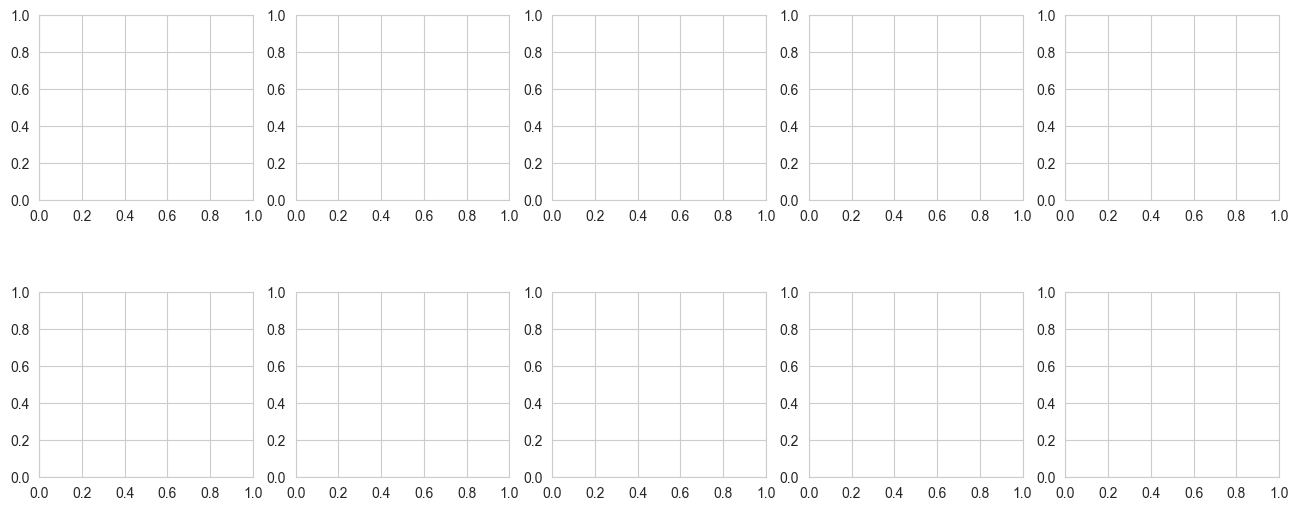

In [11]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsBase, dfGradsBase, figDBBase = cross_validate(BaseMLP, compile_args=dictCompile)
figDBBase.savefig(os.path.join(strOutputDir, 'conventional_decision_boundaries.png'))
figDBBase.savefig(os.path.join(strOutputDir, 'conventional_decision_boundaries.svg'))
figDBBase.show()

figGradsBase, axGradsBase = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsBase, x='Feature', y='Gradient', ax=axGradsBase, color='C0')
axGradsBase.set_ylabel('Gradient magnitude')
figGradsBase.savefig(os.path.join(strOutputDir, 'conventional_feature_gradients.png'))
figGradsBase.savefig(os.path.join(strOutputDir, 'conventional_feature_gradients.svg'))
figGradsBase.show()

compute_95ci(dfResultsBase)

## Meta-learning domain generalization

In [ ]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsMLDG, dfGradsMLDG, figDBMLDG = cross_validate(BaseMLP, compile_args=dictCompile, use_mldg=True)
figDBMLDG.savefig(os.path.join(strOutputDir, 'metalearning_decision_boundaries.png'))
figDBMLDG.savefig(os.path.join(strOutputDir, 'metalearning_decision_boundaries.svg'))
figDBMLDG.show()

figGradsMLDG, axGradsMLDG = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsMLDG, x='Feature', y='Gradient', ax=axGradsMLDG, color='C0')
axGradsMLDG.set_ylabel('Gradient magnitude')
figGradsMLDG.savefig(os.path.join(strOutputDir, 'metalearning_feature_gradients.png'))
figGradsMLDG.savefig(os.path.join(strOutputDir, 'metalearning_feature_gradients.svg'))
figGradsMLDG.show()

compute_95ci(dfResultsMLDG)

## Conventional MLP with additional cluster membership input

The data X and cluster membership matrix Z are simply concatenated together.

In [ ]:
dictCompile = {'loss':tf.keras.losses.BinaryCrossentropy(),
                'metrics': tf.keras.metrics.BinaryAccuracy('acc'),
                'optimizer': tf.keras.optimizers.Adam(lr=0.001)}
dfResultsConcat, dfGradsConcat, figDBConcat = cross_validate(ClusterCovariateMLP, use_z=True, compile_args=dictCompile,epochs=50)
figDBConcat.savefig(os.path.join(strOutputDir, 'concatcluster_decision_boundaries.png'))
figDBConcat.savefig(os.path.join(strOutputDir, 'concatcluster_decision_boundaries.svg'))
figDBConcat.show()

figGradsConcat, axGradsConcat = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsConcat, x='Feature', y='Gradient', ax=axGradsConcat, color='C0')
axGradsConcat.set_ylabel('Gradient magnitude')
figGradsConcat.savefig(os.path.join(strOutputDir, 'concatcluster_feature_gradients.png'))
figGradsConcat.savefig(os.path.join(strOutputDir, 'concatcluster_feature_gradients.svg'))
figGradsConcat.show()

compute_95ci(dfResultsConcat)

## Domain adversarial MLP

In [ ]:
dictBuild = {'n_clusters': dictSpiralParams['clusters'], 'adversary_layer_units': [4, 4]}
dictCompile = {'loss_gen_weight': 0.5,
               'metric_class': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsDA, dfGradsDA, figDBDA = cross_validate(DomainAdversarialMLP, use_z=True, 
                                                 build_args=dictBuild, compile_args=dictCompile)
figDBDA.savefig(os.path.join(strOutputDir, 'adversarial_decision_boundaries.png'))
figDBDA.savefig(os.path.join(strOutputDir, 'adversarial_decision_boundaries.svg'))
figDBDA.show()

figGradsDA, axGradsDA = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsDA, x='Feature', y='Gradient', ax=axGradsDA, color='C0')
axGradsDA.set_ylabel('Gradient magnitude')
figGradsDA.savefig(os.path.join(strOutputDir, 'adversarial_feature_gradients.png'))
figGradsDA.savefig(os.path.join(strOutputDir, 'adversarial_feature_gradients.svg'))
figGradsDA.show()

compute_95ci(dfResultsDA)

## GMENN

In [ ]:
config = {
"general_parameters": {
    "target": "continuous",
    "metrics": ["mse", "r2"],
    "model_name": "tabtransformer"
},  
# MENN Parameters
"menn_parameters": {
    "e_mode": "last",
    "m_mode": "all",
    "type_mcem": "SAEM", # "Vanilla" for MCEM and "SAEM" for saem
    "type_kernel": "NUTS",
    "epsilon": None,
    "set_variance_to_sample_std": True,
    "num_iters": 500,
    "num_pretrain_fe_iters": 0,
    "num_warmup_iters":  0,
    "min_samples": 1,
    "max_samples": 1,
    "print_training": 1,
    "print_warmup": 1,
    "print_pretraining": 1,
    "early_stopping_fe": 15,
    "early_stopping_metric_fe":  "val_accuracy",
    "early_stopping_re": 15,
    "early_stopping_metric_re":  "val_accuracy",
    "track_best_model": True,
    "track_best_model_metric":  "val_accuracy",
    'optimizer': tf.keras.optimizers.Adam(lr=0.001),
},

# NN Parameters
"nn_parameters": {
    "epochs": 500,
    "batch_size":  256,
    "patience": 15
},
    
# Embedding parameters
"embed_parameters": {
    "embed_dims_method": "AutoGluon" # "AutoGluon" for AutoGluon method, "sqrt" for using sqrt of number of categories, deafult=10 for all
}
}

In [ ]:
import tensorflow.keras.layers as tkl
class BaseMLPGMENN(tf.keras.Model):
    def __init__(self, name: str='mlp', **kwargs):
        """Basic MLP with 3 hidden layers of 4 neurons each.

        Args:
            name (str, optional): Model name. Defaults to 'mlp'.
        """        
        super(BaseMLPGMENN, self).__init__(name=name, **kwargs)

        self.dense0 = tkl.Dense(4, activation='relu', name=name + '_dense0')
        self.dense1 = tkl.Dense(4, activation='relu', name=name + '_dense1')
        self.dense2 = tkl.Dense(4, activation='relu', name=name + '_dense2')
        self.dense_out = tkl.Dense(1, activation='linear', name=name + '_dense_out')
        
    def call(self, inputs,training=False):
        
        x = self.dense0(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense_out(x)
        
        return x

In [ ]:
dictBuild = {"qs": [10], 
             "fe_model": BaseMLPGMENN, 
             "initial_stds": [1.], 
             "target": "binary", 
             "num_outputs": 1, 
             "RS": 283}
dictCompile = config
dfResultsGMENN, dfGradsGMENN, figDBGMENN, model = cross_validate(RandomInterceptNetwork,  
                                                                            use_z=False, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile,
                                                                                    epochs=50)
figDBGMENN.savefig(os.path.join(strOutputDir, 'GMENN_decision_boundaries.png'))
figDBGMENN.savefig(os.path.join(strOutputDir, 'GMENN_decision_boundaries.svg'))
figDBGMENN.show()

figGradsGMENN, axGradsGMENN = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsGMENN, x='Feature', y='Gradient', ax=axGradsGMENN, color='C0')
axGradsGMENN.set_ylabel('Gradient magnitude')
figGradsGMENN.savefig(os.path.join(strOutputDir, 'GMENN_feature_gradients.png'))
figGradsGMENN.savefig(os.path.join(strOutputDir, 'GMENN_feature_gradients.svg'))
figGradsGMENN.show()

compute_95ci(dfResultsGMENN)

### Slope GMENN

In [ ]:
# dfRandomSlopeSD, dfRandomIntercept

In [ ]:
dictBuild = {"qs": [10], 
             "fe_model": BaseMLPGMENN, 
             "initial_stds": [[1.]*(1+arrX.shape[1]+4)], 
             "target": "binary", 
             "num_outputs": 1, 
             "RS": 283}
dictCompile = config
dfResultsGMENN, dfGradsGMENN, figDBGMENN, model = cross_validate(RandomInterceptNetwork,  
                                                                            use_z=False, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile,
                                                                                    epochs=100)
figDBGMENN.savefig(os.path.join(strOutputDir, 'GMENN_decision_boundaries.png'))
figDBGMENN.savefig(os.path.join(strOutputDir, 'GMENN_decision_boundaries.svg'))
figDBGMENN.show()

figGradsGMENN, axGradsGMENN = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsGMENN, x='Feature', y='Gradient', ax=axGradsGMENN, color='C0')
axGradsGMENN.set_ylabel('Gradient magnitude')
figGradsGMENN.savefig(os.path.join(strOutputDir, 'GMENN_feature_gradients.png'))
figGradsGMENN.savefig(os.path.join(strOutputDir, 'GMENN_feature_gradients.svg'))
figGradsGMENN.show()

compute_95ci(dfResultsGMENN)

In [ ]:
np.array(model.random_effects)[0][0]

In [ ]:
np.array(model.effect_z_samples).shape

In [ ]:
dictBuild = {"qs": [10], 
             "fe_model": BaseMLPGMENN, 
             "initial_stds": [[1.]*(1+arrX.shape[1]+4)], 
             "target": "binary", 
             "num_outputs": 1, 
             "RS": 283}
dictCompile = config
dfResultsGMENN, dfGradsGMENN, figDBGMENN = cross_validate(RandomInterceptNetwork,  
                                                                            use_z=False, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile,
                                                                                    epochs=100)
figDBGMENN.savefig(os.path.join(strOutputDir, 'GMENN_decision_boundaries.png'))
figDBGMENN.savefig(os.path.join(strOutputDir, 'GMENN_decision_boundaries.svg'))
figDBGMENN.show()

figGradsGMENN, axGradsGMENN = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsGMENN, x='Feature', y='Gradient', ax=axGradsGMENN, color='C0')
axGradsGMENN.set_ylabel('Gradient magnitude')
figGradsGMENN.savefig(os.path.join(strOutputDir, 'GMENN_feature_gradients.png'))
figGradsGMENN.savefig(os.path.join(strOutputDir, 'GMENN_feature_gradients.svg'))
figGradsGMENN.show()

compute_95ci(dfResultsGMENN)

In [42]:
import numpy as np
# import pandas as pd

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

# from tensorflow.keras.layers import Dense, Dropout, Input
# from tensorflow.keras import Model
from tensorflow.keras.layers import ReLU
from tensorflow.keras.activations import sigmoid, softmax, linear
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score as f1
from tensorflow.keras.metrics import Accuracy,  MeanSquaredError, AUC
from tensorflow_addons.metrics import F1Score, RSquare
from sklearn.metrics import roc_auc_score
from tensorflow.keras.metrics import CategoricalAccuracy as cat_acc
import time

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

####
class RandomInterceptNetwork(tf.Module):
    '''
    Single-Category, Random-Intercept Neural Networks.

    To choose the target distribution, specify target="continuous" for regression, target="binary" for binary
    classification and target="categorical" for multi-class classification.

    To fix the stochasticity for the experiments, fix the global random seed with tf.random_seed() as well as the random
    seeds for all non-deterministic functions. The main stochasticity is from the NN initialization and the e-step

    Parameters:
        qs: List with numbers of categories per RE
        fe_model: Any keras model producing an output that fits the target distribution
        target: Target distribution, one of ["continuous", "binary", "categorical"]
        num_outputs: Output size of the fe_model. Should be 1 for continuous and binary targets and the number of
            classes for categorical.
        initial_stds: List of value(s) to initialise the std parameter(s)
        positive_constraint_method: Method used to ensure that std/variance stays positive. One of ["exp", "clip"]. Default: "clip"
        RS: Random seed

    '''
    def __init__(self, qs, fe_model, target="continuous", num_outputs=1, initial_stds=[1.], initial_error_std=1., positive_constraint_method="clip", RS=42):
        self.qs = qs
        self.RS = RS
        self.target = target
        self.num_outputs = num_outputs
        self.fe_model = fe_model
        self.initial_std = initial_stds

        if target == "continuous":
            self.link_function = linear
            self.distribution = tfd.Normal
            if positive_constraint_method == "exp":
                self._stddev_e = tfp.util.TransformedVariable(initial_error_std, bijector=tfb.Exp(), name="stddev_e")
            elif positive_constraint_method == "clip":
                self._stddev_e = tf.Variable(initial_error_std, name='stddev_e', constraint=lambda x: tf.clip_by_value(x, 1e-18, np.infty))

        elif target == "binary":
            self.link_function = sigmoid
            self.distribution = tfd.Bernoulli
        elif target == "categorical":
            self.link_function = softmax
            self.distribution = tfd.OneHotCategorical
        else:
            raise AttributeError("Invalid target type specified. Please specify the target parameter as one of \
                                 ['continuous', 'binary', 'categorical']")

        # Initialize sig2b
        if positive_constraint_method=="exp":
            self._stddev_z = [tfp.util.TransformedVariable(std, bijector=tfb.Exp(), name=f"stddev_z{num}") for num, std in enumerate(self.initial_std)]
        elif positive_constraint_method=="clip":
            self._stddev_z = [tf.Variable(std, name=f'stddev_z{num}', constraint=lambda x: tf.clip_by_value(x, 1e-18, np.infty)) for num, std in enumerate(self.initial_std)]


    def __call__(self, X, Z, training=False):
#         X_random = tf.concat([tf.ones([X.shape[0],1]),X],axis=1)
        
        curr = X
        for i in self.fe_model.layers[:-1]:
            if "dense" in str(i.name):
                curr = i(curr)        
        
        X_random = tf.concat([tf.ones([X.shape[0],1]),X,curr],axis=1)
        
        
        # Let W, b be the parameters of the NN f, b the random effects and sigma the variance of the random effect.
        # Let Rho be the set of all parameters {W, b, sigma}

        # For regression, we assume y ~ Normal(f(X) + b, 1) where b ~ Normal(0, sigma)
        # Hence the probability density function is pdf(y; f(X)+b, 1) = exp(-0.5 (y-(f(x)+b))**2) / (2 pi)**0.5
        # Alternatively, we could formulate the problem like Simchoni as y ~ Normal(f(X), V(sigma))
        if self.target == "continuous":
            priors = [
                # Set up prior distribution Normal(b; 0, sigma)
                tfd.MultivariateNormalDiag(
                    loc=tf.zeros([1+X.shape[1],self.qs[num]]),
                    scale_identity_multiplier=self._stddev_z[num])
                for num in range(len(self._stddev_z))]


            likelihood = lambda *effect_z: tfd.Independent(
                self.distribution(
                    loc = tf.experimental.numpy.ravel(self.fe_model(X, training)) +
                          tf.reduce_sum([tf.gather(effect_z[len(self.qs)-1-num], Z[:, num]) for num in range(len(self.qs))], axis=0),
                    scale=self._stddev_e
                ),
                reinterpreted_batch_ndims=1)

        # For binary classification, we assume y ~ Bernoulli(eta) where eta = f(X) + b and b ~ Normal(0, sigma)
        elif self.target == "binary":
            priors = [
                # Set up prior distribution Normal(b; 0, sigma)
                tfd.MultivariateNormalDiag(
                    loc=tf.zeros([1+X.shape[1]+curr.shape[1],self.qs[num]]),
                    scale_identity_multiplier=self._stddev_z[num])
                for num in range(len(self._stddev_z))]

            likelihood = lambda *effect_z: tfd.Independent(
                self.distribution(
                    logits = tf.experimental.numpy.ravel(self.fe_model(X, training)) +
                          tf.reduce_sum([tf.reduce_sum(tf.multiply(X_random,tf.transpose(tf.gather(effect_z[len(self.qs)-1-num],Z[:,num],axis=1))),axis=1) for num in range(len(self.qs))], axis=0)
                ),
                reinterpreted_batch_ndims=1)

        # For multi-class classification, we assume y ~ Categorical(eta) where eta = f(X) + b and b ~ Normal(0, sigma) and b is a matrix q*c
        elif self.target == "categorical":
            priors = [
                # Set up prior distribution Normal(b; 0, sigma)
                tfd.MultivariateNormalDiag(
                    loc=tf.zeros([1+X.shape[0],self.num_outputs,self.qs[num]]),
                    scale_identity_multiplier=self._stddev_z[num])
                for num in range(len(self._stddev_z))]

            likelihood = lambda *effect_z: tfd.Independent(
                self.distribution(
                    logits = self.fe_model(X, training) +
                             tf.reduce_sum([tf.transpose(tf.gather(effect_z[len(self.qs)-1-num], Z[:, num],axis=1)) for num in range(len(self.qs))], axis=0),
                ),
                reinterpreted_batch_ndims=1)

        # Set the joint distribution as the prior and likelihood for the observed.
        joint = priors + [likelihood]

        # The MLE is solved as min_{W,b,sigma} -log p(y | X, Z; W, b, sigma) = min_{W,b,sigma} -log integral[ p(b; sigma) p(y | X, Z, b; W, b) db
        model = tfd.JointDistributionSequentialAutoBatched(joint)

        model._to_track = self

        return model

    def trace_mcmc(self, states, previous_kernel_results):
        try:
            return previous_kernel_results.log_accept_ratio
        except:
            return previous_kernel_results.inner_results.log_accept_ratio

    # # Set up E-step (MCMC).
    # @tf.function()#autograph=False, jit_compile=True, reduce_retracing=True)
    # def get_mcmc_samples(self, current_state, num_mcmc_samples=tf.constant(1)):

    #     samples, log_accept_ratio = tfp.mcmc.sample_chain(
    #             kernel=self.mcmc_kernel, num_results=num_mcmc_samples, current_state=current_state,
    #             trace_fn= self.trace_mcmc)

    #     acceptance_rate = tf.math.exp(tf.minimum(log_accept_ratio, 0.))

    #     return samples, acceptance_rate

    @tf.function()#autograph=False, jit_compile=True, reduce_retracing=True)
    def get_mcmc_samples(self, current_state, previous_kernel_results, num_mcmc_samples=1):

        samples, _, previous_kernel_results = tfp.mcmc.sample_chain(
                kernel=self.mcmc_kernel, num_results=num_mcmc_samples, current_state=current_state,
                trace_fn= None, previous_kernel_results = previous_kernel_results,
                return_final_kernel_results=True,seed=self.RS)
        try:
            log_accept_ratio = previous_kernel_results.log_accept_ratio
        except:
            log_accept_ratio = previous_kernel_results.inner_results.log_accept_ratio
        acceptance_rate = tf.math.exp(tf.minimum(log_accept_ratio, 0.))

        return samples, acceptance_rate, previous_kernel_results

    # Set up M-step (gradient descent).
    @tf.function()#autograph=False, jit_compile=True, reduce_retracing=True)
    def FE_update_mean_vanilla(self, X, Z, y, current_state):
        zero_state = [tf.zeros(state[0].shape, dtype=tf.float32) for state in current_state]
        with tf.GradientTape() as tape:
            loss = -self(X, Z, training=True).log_prob(current_state + [y]) - tf.reduce_mean(self(X, Z, training=True).log_prob(zero_state + [y]))
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fe.apply_gradients(zip(grads,self.trainable_variables))

        return loss, grads

    @tf.function()#autograph=False, jit_compile=True, reduce_retracing=True)
    def FE_update_mean_saem(self, X, Z, y, current_state, previous_loss, iteration_step):
        zero_state = [tf.zeros(state[0].shape, dtype=tf.float32) for state in current_state]
        with tf.GradientTape() as tape:
            vanilla_loss = -self(X, Z, training=True).log_prob(current_state + [y])  - tf.reduce_mean(self(X, Z, training=True).log_prob(zero_state + [y]))
            update_loss = tf.cast(tf.math.subtract(vanilla_loss, previous_loss), tf.float32)
            update_iteration = tf.cast(tf.math.divide(1, iteration_step), tf.float32)
            loss = tf.math.add(previous_loss, tf.math.multiply(update_iteration, update_loss))
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fe.apply_gradients(zip(grads,self.trainable_variables))

        return loss, grads

    @tf.function()#autograph=False, jit_compile=True, reduce_retracing=True)
    def FE_update_all_vanilla(self, X, Z, y, current_state):
        zero_state = [tf.zeros(state[0].shape, dtype=tf.float32) for state in current_state]
        with tf.GradientTape() as tape:
            loss = -tf.reduce_mean(self(X, Z, training=True).log_prob(current_state + [y])) - tf.reduce_mean(self(X, Z, training=True).log_prob(zero_state + [y]))
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fe.apply_gradients(zip(grads,self.trainable_variables))

        return loss, grads

    @tf.function()#autograph=False, jit_compile=True, reduce_retracing=True)
    def FE_update_all_saem(self, X, Z, y, current_state, previous_loss, iteration_step):
        zero_state = [tf.zeros(state[0].shape, dtype=tf.float32) for state in current_state]
        with tf.GradientTape() as tape:
            vanilla_loss = -tf.reduce_mean(self(X, Z, training=True).log_prob(current_state + [y])) - tf.reduce_mean(self(X, Z, training=True).log_prob(zero_state + [y]))
            update_loss = tf.cast(tf.math.subtract(vanilla_loss, previous_loss), tf.float32)
            update_iteration = tf.cast(tf.math.divide(1, iteration_step), tf.float32)
            loss = tf.math.add(previous_loss, tf.math.multiply(update_iteration, update_loss))
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fe.apply_gradients(zip(grads,self.trainable_variables))

        return loss, grads


    def one_iteration(self, X, Z, y, current_state, previous_kernel_results, num_mcmc_samples, previous_loss, iteration_step, set_variance_to_sample_std=True):
        # In the e-step the expectation of the complete log-likelihood is determined w.r.t. the conditional distribution p(b | f(X), y)
        e_start = time.time()
        if self.e_mode == "mean":
            input_sample = [tf.reduce_mean(q_state, axis=0) for q_state in current_state]
        elif self.e_mode =="last":
            input_sample = [q_state[-1] for q_state in current_state]
        next_state, acceptance_rate, previous_kernel_results = self.get_mcmc_samples(input_sample, previous_kernel_results, tf.constant(num_mcmc_samples))
        e_end = time.time()

        # The m-step updates p(y | Rho) w.r.t. W, b & sigma
        # The posterior MCMC sample is used to calculate an unbiased estimate of the matginal likelihood up to a constant
        m_start = time.time()
        # Update FE part
        if self.m_mode == "all":
            if not self.fe_converged:
                for index, offset in enumerate(range(0, self.train_size, self.batch_size)):
                    print(f"batch {index}", end="\r")
                    X_batch = X[offset: offset + self.batch_size]
                    Z_batch = Z[offset: offset + self.batch_size]
                    y_batch = y[offset: offset + self.batch_size]

                    if self.type_mcem == "Vanilla":
                        loss, grads = self.FE_update_all_vanilla(X_batch, Z_batch, y_batch, next_state)
                    else:
                        loss, grads = self.FE_update_all_saem(X_batch, Z_batch, y_batch, next_state, previous_loss, iteration_step)
            else:
                loss = -tf.reduce_mean(self.target_log_prob_fn(*zip(next_state)))

                if self.type_mcem == 'SAEM':
                    update_loss = tf.cast(tf.math.subtract(loss, previous_loss), tf.float32)
                    update_iteration = tf.cast(tf.math.divide(1, iteration_step), tf.float32)
                    loss = tf.math.add(previous_loss, tf.math.multiply(update_iteration, update_loss))

                grads = [tf.zeros(i.shape) for i in self.trainable_variables]
        elif self.m_mode == "mean":
            if not self.fe_converged:
                next_state_mean = [tf.reduce_mean(q_state, axis=0) for q_state in next_state]
                for index, offset in enumerate(range(0, self.train_size, self.batch_size)):
                    print(f"batch {index}", end="\r")
                    X_batch = X[offset: offset + self.batch_size]
                    Z_batch = Z[offset: offset + self.batch_size]
                    y_batch = y[offset: offset + self.batch_size]
                    if self.type_mcem == "Vanilla":
                        loss, grads = self.FE_update_mean_vanilla(X_batch, Z_batch, y_batch, next_state_mean)
                    else:
                        loss, grads = self.FE_update_all_saem(X_batch, Z_batch, y_batch, next_state_mean, previous_loss, iteration_step)
            else:
                loss = -tf.reduce_mean(self.target_log_prob_fn(*zip(next_state)))
                if self.type_mcem == 'SAEM':
                    update_loss = tf.cast(tf.math.subtract(loss, previous_loss), tf.float32)
                    update_iteration = tf.cast(tf.math.divide(1, iteration_step), tf.float32)
                    loss = tf.math.add(previous_loss, tf.math.multiply(update_iteration, update_loss)) 
                grads = [tf.zeros(i.shape) for i in self.trainable_variables]

        # Update RE part
        if set_variance_to_sample_std:
            for num, q_num in enumerate(np.where(self.z_indicator)[0]):
                if not self.re_converged[num]:
                    if self.target == "categorical":
                        self.trainable_variables[q_num].assign(tf.math.reduce_std(tf.math.reduce_mean(next_state[num],axis=0),axis=1))
                    else:
                        self.trainable_variables[q_num].assign(tf.math.reduce_std(tf.math.reduce_mean(next_state[num],axis=0),axis=-1))
        m_end = time.time()

        return loss, grads, next_state, e_end-e_start, m_end-m_start, acceptance_rate.numpy(), previous_kernel_results




    def get_mcmc_kernel_init_func(self, type_mcem: str = 'Vanilla', type_kernel: str = 'NUTS', epsilon: float = None, num_of_steps: int = None, min_samples:int = 1, max_samples: int = 1):

        '''
        Implements three different types of Markov Chain Monte Carlo transition kernels:

        -the No U-Turn Sampler, NUTS
        -Hamiltonian Monte Carlo, HMC
        -Metropolis Adjusted Langevin Algorithm, MALA

        Args:
        -type_mcem: the type of Monte Carlo Expectation Maximization (MCEM) Method. Allowed values: ['SAEM', 'Vanilla']
        -type_kernel: required, specifies the type of MCMC. Allowed values: ['NUTS', 'HMC', 'MALA']
        -epsilon: optional, a positive float, defines the step width, if no value is given Dual Averaging is used
        with the optimal acceptance rate for the respective MCMC type. Find out more in Hoffman's canonical paper:
        http://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf
        -num_of_steps: required for HMC, a positive integer, the number of steps used by HMC. If you are unsure about
        num_of_steps consider switching to NUTS as that's HMC with an automatic number of steps selection.
        '''

        if type_mcem not in ['SAEM', 'Vanilla']:
            raise AttributeError(f"Unallowed Monte Carlo Expectation Maximization. Current value: {type_mcem}. Allowed values: ['SAEM', 'Vanilla']")
        #MC Initialization
        num_adaption_steps = 500 #similar to burnin for dual averaging
        self.min_samples = min_samples
        self.max_samples = max_samples
        self.type_mcem = type_mcem

        if epsilon is None:
            step_size = 0.01
        else:
            step_size = epsilon

        if max_samples < min_samples:
            print(f"From a Monte Carlo perspective it makes more sense to have min_samples <= max_samples.\
            Current values are min_samples: {min_samples}, max_samples: {max_samples}.")

        if type_kernel == "NUTS":

            target_accept_prob = 0.651

            kernel_out = lambda target_log_prob_fn: tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn=target_log_prob_fn,
                step_size=step_size)

            if epsilon is None:

                kernel_out = lambda target_log_prob_fn:  tfp.mcmc.DualAveragingStepSizeAdaptation(
                                inner_kernel=tfp.mcmc.NoUTurnSampler(
                                target_log_prob_fn=target_log_prob_fn,
                                step_size=step_size),
                                num_adaptation_steps=num_adaption_steps,
                                target_accept_prob = target_accept_prob)

                # kernel_out_adap = lambda kernel_out:  tfp.mcmc.DualAveragingStepSizeAdaptation(
                #                 inner_kernel=kernel_out, num_adaptation_steps=num_adaption_steps,
                #                 target_accept_prob = target_accept_prob)

        elif type_kernel == "HMC":

            target_accept_prob = 0.651

            if isinstance(num_of_steps, int):

                kernel_out = lambda target_log_prob_fn: tfp.mcmc.HamiltonianMonteCarlo(
                                target_log_prob_fn=target_log_prob_fn,
                                step_size=step_size, num_leapfrog_steps = num_of_steps)

                if epsilon is None:

                    kernel_out = lambda target_log_prob_fn: tfp.mcmc.DualAveragingStepSizeAdaptation(
                                    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                                    target_log_prob_fn=target_log_prob_fn,
                                    step_size=step_size, num_leapfrog_steps = num_of_steps),
                                    num_adaptation_steps=num_adaption_steps,
                                    target_accept_prob = target_accept_prob)

            else:

                raise AttributeError("Invalid value for num_of_steps. Please specify an integer or consider switching \
                                        to NUTS by specifying type = 'NUTS' for adaptive number of steps (e.g. no user input required).")


        elif type_kernel == "MALA":

            target_accept_prob = 0.574

            kernel_out = lambda target_log_prob_fn: tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
                            target_log_prob_fn=target_log_prob_fn,
                            step_size=step_size)

            if epsilon is None:

                raise AttributeError("Please specify epsilon for MALA as Dual Averaging is not supported for MALA.")

        else:

            raise AttributeError("Invalid MCMC type specified. Please select type_kernel from \
                                ['NUTS', 'HMC', MALA']. Currently selected type is: " + type_kernel + ".")
        return(kernel_out)

    def fit(self, X, y, Z,
            val_data=None,
            mcmc_kernel_init_func = lambda x: x, num_mcmc_samples=1,
            e_mode="last", m_mode = "all",
            optimizer_fe=Adam(), set_variance_to_sample_std=True,
            batch_size=100,
            num_iters=1500,
            num_pretrain_fe_iters = 0, num_warmup_iters=0, perc_burnin=0.1,
            print_warmup=500, print_pretraining=5, print_training=500,
            early_stopping_fe=None, early_stopping_metric_fe="train_loss",
            early_stopping_re=None, early_stopping_metric_re="train_loss",
            metrics=[], num_samples_use_for_pred="posterior_mean",
            track_best_model=False, track_best_model_metric = "train_loss"):

        fit_start = time.time()
        self.num_mcmc_samples = num_mcmc_samples
        self.e_mode = e_mode
        self.m_mode = m_mode
        self.optimizer_fe = optimizer_fe
        self.batch_size = batch_size
        self.num_warmup_iters = num_warmup_iters
        self.num_pretrain_fe_iters = num_pretrain_fe_iters
        self.num_iters = num_iters
        self.num_iters_actual = num_iters
        self.effect_z_samples = [[] for _ in range(len(self.qs))]
        self.early_stopping_fe = early_stopping_fe
        self.early_stopping_metric_fe = early_stopping_metric_fe
        self.early_stopping_re = early_stopping_re
        self.early_stopping_metric_re = early_stopping_metric_re
        self.track_best_model = track_best_model
        self.track_best_model_metric = track_best_model_metric
        self.loss_history = {"train_loss": [],
                             "z": [],
                             "z_grads": [],
                             "z_change": [],
                             "fe_grads_absmean": [],
                             "acceptance_rate": [],
                             "fe_loss": [],
                             "re_loss": [],
                             "e_step_time": [],
                             "m_step_time": [],
                             "postprocessing_time": []
                             }
        if self.target == "continuous":
            self.loss_history["e"] = []

        self.fe_converged=False
        self.re_converged=[False]*len(self.qs)

        for metric in metrics:
            self.loss_history["train_" + metric] = []
            self.loss_history["fe_"+ "train_" + metric] = []

        if self.target == "categorical":
            y = tf.one_hot(y, self.num_outputs)

        if not tf.is_tensor(X):
            X = tf.convert_to_tensor(X, dtype=tf.float32)
        if not tf.is_tensor(y):
            y = tf.convert_to_tensor(y,dtype=tf.float32)
        if not tf.is_tensor(Z):
            Z = tf.convert_to_tensor(Z,dtype=tf.int32)


        # The joint distribution is defined with the fixed variables
        data_model = self(X, Z)
        # To obtain the loss function, we pass the sampled vector b and y to compute the log probability of the posterior
        self.target_log_prob_fn = tf.function(lambda *x: data_model.log_prob(x + (y,)))
        self.target_log_prob_parts_fn = tf.function(lambda *x: data_model.log_prob_parts(x + (y,)))

        if val_data is not None:
            X_val, y_val, Z_val = val_data

            if not tf.is_tensor(X_val):
                X_val = tf.convert_to_tensor(X_val,dtype=tf.float32)
            if not tf.is_tensor(y_val):
                if self.target == "continuous":
                    y_val = tf.convert_to_tensor(y_val,dtype=tf.float32)
                else:
                    y_val = tf.convert_to_tensor(y_val,dtype=tf.int32)
            if not tf.is_tensor(Z_val):
                Z_val = tf.convert_to_tensor(Z_val,dtype=tf.int32)

            if self.target == "categorical":
                y_val = tf.one_hot(y_val, self.num_outputs)

            data_model_val = self(X_val, Z_val)
            self.target_log_prob_fn_val = tf.function(lambda *x: data_model_val.log_prob(x + (y_val,)))  # /len(labels_train)
            self.target_log_prob_parts_fn_val = tf.function(lambda *x: data_model_val.log_prob_parts(x + (y_val,)))  # /len(labels_train)
            self.loss_history["val_loss"] = []
            self.loss_history["fe_loss_val"] = []
            for metric in metrics:
                self.loss_history["val_" + metric] = []
                self.loss_history["fe_" + "val_" + metric] = []

        self.mcmc_kernel = mcmc_kernel_init_func(self.target_log_prob_fn)

        # The initial state for HMC is randomly sampled from the prior distribution
        current_state = data_model.sample(1, seed=self.RS)[:-1]
        # kernel_results = mcmc_kernel.bootstrap_results(current_state)
        previous_kernel_results = None

        self.z_indicator = [i.name in [f'stddev_z{num}:0' for num in range(len(self.qs))] for i in self.trainable_variables]
        self.train_size = X.shape[0]



        if early_stopping_fe is not None:
            if early_stopping_metric_fe in ["train_accuracy", "val_accuracy", "train_f1", "val_f1", "train_auc",
                                         "val_auc"]:
                current_best_fe = -np.inf
            else:
                current_best_fe = np.inf

        if early_stopping_re is not None:
            if early_stopping_metric_re in ["train_accuracy", "val_accuracy", "train_f1", "val_f1", "train_auc",
                                         "val_auc"]:
                current_best_re = [-np.inf]*len(self.qs)
            else:
                current_best_re = [np.inf]*len(self.qs)
            early_stop_re = [0] * len(self.qs)

        # Run FE model pretraining with 0-RE variance assumption
        if self.num_pretrain_fe_iters>0:
            zero_state = [tf.zeros(state[0].shape, dtype=tf.float32) for state in current_state]
            last_loss = np.inf
            if val_data is not None:
                last_val_loss = np.inf

            for t in range(num_pretrain_fe_iters):
                with tf.GradientTape() as tape:
                    loss = -self.target_log_prob_fn(*zero_state)
                grads = tape.gradient(loss, self.trainable_variables)
                self.optimizer_fe.apply_gradients(zip(grads, self.trainable_variables))

                if val_data is not None:
                    val_loss = -self.target_log_prob_fn_val(*zero_state).numpy()

                if t % print_pretraining == 0 or t == num_pretrain_fe_iters - 1:
                    fe_str = "FE Pretraining Iteration: {:>3} Loss: {:.3f}".format(
                        t, loss)
                    if val_data is not None:
                        fe_str += ", Validation Loss: {:.3f}".format(val_loss)
                    print(fe_str)

                if val_data is not None:
                    if last_val_loss<val_loss:
                        break
                    else:
                        last_val_loss = val_loss
                else:
                    if last_loss<loss:
                        break
                    else:
                        last_loss = loss

        # Run warm-up stage.
        if num_warmup_iters>0:
            num_mcmc_samples_warmup = np.concatenate([[0+i]*round(self.num_warmup_iters/self.max_samples) for i in range(self.min_samples,self.max_samples+1)])[:self.num_warmup_iters].astype(np.int32)
            for t in range(num_warmup_iters):
                # last_state = current_state
                start = time.time()
                if self.e_mode == "mean":
                    input_sample = [tf.reduce_mean(q_state, axis=0) for q_state in current_state]
                elif self.e_mode == "last":
                    input_sample = [q_state[-1] for q_state in current_state]
                current_state, acceptance_rate, previous_kernel_results = self.get_mcmc_samples(input_sample, previous_kernel_results, num_mcmc_samples_warmup[t])
                end = time.time()
                print("E-step Time in Sec.=: ", round(end - start, 2))

                if t % print_warmup == 0 or t == num_warmup_iters - 1:
                    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
                        t, tf.reduce_mean(acceptance_rate).numpy()))

            if set_variance_to_sample_std:
                for num,q_num in enumerate(np.where(self.z_indicator)[0]):
                    if not self.re_converged[num]:
                        if self.target == "categorical":
                            self.trainable_variables[q_num].assign(
                                tf.math.reduce_std(tf.math.reduce_mean(current_state[num], axis=0), axis=1))
                        else:
                            self.trainable_variables[q_num].assign(
                                tf.math.reduce_std(tf.math.reduce_mean(current_state[num], axis=0)))

        if self.track_best_model:
            if self.track_best_model_metric in ["train_accuracy", "val_accuracy", "train_f1", "val_f1", "train_auc", "val_auc"]:
                self.best_score = -np.inf
            else:
                self.best_score = np.inf


        # Run training.
        num_mcmc_samples_training = np.concatenate([[0+i]*round(self.num_iters/self.max_samples) for i in range(self.min_samples,self.max_samples+1)])[:self.num_iters].astype(np.int32)
        previous_loss = -tf.reduce_mean(self.target_log_prob_fn(*zip(current_state)))
        for t in range(num_iters):
            iteration_step = tf.convert_to_tensor(t+1, dtype=tf.int32)
            loss, grads, current_state, e_time, m_time, acceptance_rate, previous_kernel_results = self.one_iteration(X, Z, y, current_state, previous_kernel_results, num_mcmc_samples_training[t], previous_loss, iteration_step)
            previous_loss = loss

            start_postprocessing = time.time()

            if self.m_mode =="all":
                loss = -tf.reduce_mean(self.target_log_prob_fn(*zip(current_state)))
                log_prob_parts = [-tf.reduce_mean(i).numpy() for i in self.target_log_prob_parts_fn(*current_state)]
            elif self.m_mode == "mean":
                current_state_mean = [tf.reduce_mean(q_state, axis=0) for q_state in current_state]
                loss = -self.target_log_prob_fn(*current_state_mean)
                log_prob_parts = [-i.numpy() for i in self.target_log_prob_parts_fn(*current_state_mean)]

            for q in range(len(self.qs)):
                self.effect_z_samples[q] += [i.numpy() for i in current_state[q]]

            self.random_effects = [np.mean(effect[round(t*(perc_burnin)):], axis=0) for effect in self.effect_z_samples]

            self.loss_history["e_step_time"].append(e_time)
            self.loss_history["m_step_time"].append(m_time)
            self.loss_history["train_loss"].append(loss.numpy())
            if self.target=="continuous":
                self.loss_history["e"].append(self._stddev_e.numpy())
            self.loss_history["z"].append([i.numpy() for i in self._stddev_z])
            self.loss_history["z_grads"].append(grads[:len(self.qs)])
#             self.loss_history["fe_grads_absmean"].append([np.mean(np.abs(i)) for i in grads[len(self.qs):]])
            self.loss_history["acceptance_rate"] += [acceptance_rate]
            self.loss_history["re_loss"].append(list([i for i in log_prob_parts[:-1]]))
            self.loss_history["fe_loss"].append(log_prob_parts[-1])
            if t==0:
                self.loss_history["z_change"].append([0.011]*len(self.qs))
            else:
                self.loss_history["z_change"].append(
                    [np.abs(np.array(self.loss_history["z"])[-1, q_num] - np.array(self.loss_history["z"])[-2, q_num])
                     for q_num in range(len(self.qs))])

            if len(metrics)>0:
                eval_results_train = self.evaluate(metrics, X, y, Z, num_samples_use_for_pred)
                eval_results_train_fe = self.evaluate(metrics, X, y)
                for metric in metrics:
                    self.loss_history["train_" + metric].append(eval_results_train[metric])
                    self.loss_history["fe_" + "train_" + metric].append(eval_results_train_fe[metric])

            if val_data is not None:
                if self.m_mode == "all":
                    val_loss = -tf.reduce_mean(self.target_log_prob_fn_val(*current_state)).numpy()
                    log_prob_parts_val = [-tf.reduce_mean(i).numpy() for i in self.target_log_prob_parts_fn_val(*current_state)]
                elif self.m_mode == "mean":
                    current_state_mean = [tf.reduce_mean(q_state, axis=0) for q_state in current_state]
                    val_loss = -self.target_log_prob_fn_val(*current_state_mean).numpy()
                    log_prob_parts_val = [-i.numpy() for i in self.target_log_prob_parts_fn_val(*current_state_mean)]

                self.loss_history["val_loss"].append(val_loss)
                self.loss_history["fe_loss_val"].append(log_prob_parts_val[-1])

                if len(metrics)>0:
                    eval_results_val = self.evaluate(metrics, X_val, y_val, Z_val, num_samples_use_for_pred)
                    eval_results_val_fe = self.evaluate(metrics, X_val, y_val)
                    for metric in metrics:
                        self.loss_history["val_" + metric].append(eval_results_val[metric])
                        self.loss_history["fe_"+ "val_" + metric].append(eval_results_val_fe[metric])

            ### Verbose Todo: Implement as Callback function
            if t % print_training == 0 or t == num_iters - 1:
                print("--------------------------------------------")
                print_str = "Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}, FE_Loss: {:.3f}, RE_Loss_sum: {:.3f}".format(
                    t, tf.reduce_mean(acceptance_rate).numpy(), self.loss_history["train_loss"][t],
                    self.loss_history["fe_loss"][t], np.sum(self.loss_history["re_loss"][t]))
                if len(metrics)>0:
                    for metric in metrics:
                        print_str += ", train_{}: {:.3f}".format(metric, self.loss_history["train_" + metric][t])
                        print_str += ", fe_train_{}: {:.3f}".format(metric, self.loss_history["fe_" + "train_" + metric][t])

                if val_data is not None:
                    print_str += "\n" + " Validation Loss: {:.3f}, , FE_Loss_val: {:.3f}".format(
                        self.loss_history['val_loss'][-1],
                        self.loss_history["fe_loss_val"][t])
                    if len(metrics) > 0:
                        for metric in metrics:
                            print_str += ", val_{}: {:.3f}".format(metric, self.loss_history["val_" +metric][t])
                            print_str += ", fe_val_{}: {:.3f}".format(metric,self.loss_history["fe_" + "val_" + metric][t])
                print(print_str)

            ### Track best model parameters Todo: Implement as Callback function
            if self.track_best_model:
                if self.track_best_model_metric in ["train_accuracy", "val_accuracy", "train_f1", "val_f1", "train_auc", "val_auc"]:
                    track_best_condition = self.best_score<self.loss_history[self.track_best_model_metric][t]
                else:
                    track_best_condition = self.best_score>self.loss_history[self.track_best_model_metric][t]
                if track_best_condition:
                    self.best_score = self.loss_history[self.track_best_model_metric][t]
                    self.best_parameters = [i.numpy() for i in self.trainable_variables]
                    self.best_iteration = t

            ### Early stopping FE Todo: Implement as Callback function
            if early_stopping_fe is not None:
                if not self.fe_converged:
                    if early_stopping_metric_fe in ["train_accuracy", "val_accuracy", "train_f1", "val_f1", "train_auc", "val_auc"]:
                        early_stop_condition_fe = self.loss_history[early_stopping_metric_fe][-1] <= current_best_fe
                    else:
                        early_stop_condition_fe = self.loss_history[early_stopping_metric_fe][-1] >= current_best_fe

                    if early_stop_condition_fe:
                        early_stop_fe += 1
                    else:
                        early_stop_fe = 0
                        current_best_fe = self.loss_history[early_stopping_metric_fe][-1]
                    if early_stop_fe==early_stopping_fe:
                        print(f"Early stopping of FE by {early_stopping_metric_fe} at {t} iterations")
                        self.fe_converged = True

            ### Early stopping RE Todo: Implement as Callback function
            if early_stopping_re is not None:
                for q_num in range(len(self.qs)):
                    if not self.re_converged[q_num]:
                        # Test whether metric is RE-specific or same for all
                        if len(np.array(self.loss_history[early_stopping_metric_re]).shape) == 1:
                            current_metric = self.loss_history[early_stopping_metric_re][-1]
                        else:
                            current_metric = self.loss_history[early_stopping_metric_re][-1][q_num]

                        if early_stopping_metric_re in ["train_accuracy", "val_accuracy", "train_f1", "val_f1",
                                                        "train_auc", "val_auc"]:
                            early_stop_condition_re = current_metric <= current_best_re[q_num]
                        elif early_stopping_metric_re == "z_change":
                            early_stop_condition_re = current_metric <= 0.01
                        else:
                            early_stop_condition_re = current_metric >= current_best_re[q_num]

                        if early_stop_condition_re:
                            early_stop_re[q_num] += 1
                        else:
                            early_stop_re[q_num] = 0
                            current_best_re[q_num] = current_metric
                        if early_stop_re[q_num] == early_stopping_re:
                            print(f"Early stopping of RE{q_num} by {early_stopping_metric_re} at {t} iterations")
                            self.re_converged[q_num] = True

            end_postprocessing = time.time()
            if t % print_training == 0 or t == num_iters - 1:
                print("E-step Time in Sec.=: ", round(e_time, 2))
                print("M-step Time in Sec.=: ", round(m_time, 2))
                print("Postprocessing Time in Sec.=: ", round(end_postprocessing - start_postprocessing, 2))

                self.loss_history["postprocessing_time"].append(end_postprocessing - start_postprocessing)

            if all(self.re_converged+[self.fe_converged]):
                self.num_iters_actual = t + 1
                break

        # The random effects are obtained as the inferred posterior mean of sampled values over the iterations
        self.random_effects = [np.mean(effect[round(self.num_iters_actual*(perc_burnin)):],axis=0) for effect in self.effect_z_samples]

        fit_end = time.time()
        self.total_fit_time = fit_end-fit_start


    def evaluate(self, metrics, X, y, Z=None, num_samples_use="posterior_mean"):
        '''
        Currently supported metrics:
            Regression: MSE, R2
            Classification: Accuracy, F1 (macro), ROC-AUC
        '''
        if num_samples_use!="posterior_mean" and num_samples_use>len(self.loss_history["effect_z_samples"]):
            num_samples_use = "posterior_mean"

        if Z is not None:
            y_pred = self.predict(X, Z, num_samples_use)
        else:
            y_pred = self.predict(X)

        res_metrics = {}
        if self.target=="continuous":
            y_pred = tf.reshape(y_pred,-1)
            if "mse" in metrics:
                res_metrics["mse"] = MeanSquaredError()(y,y_pred).numpy()
            if "r2" in metrics:
                res_metrics["r2"] = RSquare()(y,y_pred).numpy()

        if self.target == "binary":
            if "accuracy" in metrics:
                res_metrics["accuracy"] = Accuracy()(y,np.round(y_pred)).numpy()
            if "f1" in metrics:
                res_metrics["f1"] = f1(y,np.round(y_pred))
            if "auc" in metrics:
                res_metrics["auc"] = roc_auc_score(y,y_pred)

        if self.target == "categorical":
            # If y is a vector
            if len(y.shape)==1:
                if "accuracy" in metrics:
                    res_metrics["accuracy"] = cat_acc()(tf.one_hot(y,self.num_outputs), y_pred).numpy().numpy()
                if "f1" in metrics:
                    res_metrics["f1"] = F1Score(num_classes=self.num_outputs, average="macro")(tf.one_hot(y,self.num_outputs),y_pred).numpy()
                if "auc" in metrics:
                    res_metrics["auc"] = roc_auc_score(y,y_pred, multi_class="ovo", average="macro")
            # If y is sparse - one hot encoded
            else:
                if "accuracy" in metrics:
                    res_metrics["accuracy"] = cat_acc()(y, y_pred).numpy()
                if "f1" in metrics:
                    res_metrics["f1"] = F1Score(num_classes=self.num_outputs, average="macro")(y,y_pred).numpy()
                if "auc" in metrics:
                    res_metrics["auc"] = roc_auc_score(y,y_pred, multi_class="ovo", average="macro")

        if len(res_metrics)==0:
            raise Warning("The provided metrics are inappropriate for the target or not supported")

        return res_metrics

    def predict(self, X, Z=None, num_samples_use="posterior_mean"):
        if not tf.is_tensor(X):
            X = tf.convert_to_tensor(X)
#         X_random = tf.concat([tf.ones([X.shape[0],1]),X],axis=1)
        curr = X
        for i in self.fe_model.layers[:-1]:
            if "dense" in str(i.name):
                curr = i(curr)        

        res = self.fe_model(X,training=False)

        if Z is not None:
            X_random = tf.concat([tf.ones([X.shape[0],1]),X,curr],axis=1)
            
            if num_samples_use=="posterior_mean":
                if self.target in ["continuous", "binary"]:
                    res = tf.experimental.numpy.ravel(res) + tf.reduce_sum([tf.reduce_sum(tf.multiply(X_random,tf.transpose(tf.gather(self.random_effects[num],Z[:,num],axis=1))),axis=1) for num in range(len(self.qs))], axis=0)
                elif self.target == "categorical":
                    res = res + tf.reduce_sum([tf.transpose(tf.gather(self.random_effects[num], Z[:, num],axis=1)) for num in range(len(self.qs))], axis=0)
            else:

                if self.target in ["continuous", "binary"]:
                    samples = [[self.effect_z_samples[q][i] for q in range(len(self.qs))] for i in
                               range(-num_samples_use, 0)]
                    res = tf.reduce_mean([tf.experimental.numpy.ravel(res) + tf.reduce_sum(
                        [tf.reduce_sum(tf.multiply(X_random,tf.transpose(tf.gather(sample,Z,axis=1))),axis=1) for num in range(len(self.qs))], axis=0) for sample in
                                          samples], axis=0)
                elif self.target == "categorical":
                    samples = [[self.effect_z_samples[q][i] for q in range(len(self.qs))] for i in
                               range(-num_samples_use, 0)]
                    res = tf.reduce_mean([res + tf.reduce_sum([tf.transpose(tf.gather(sample[num], Z[:, num],axis=1))
                                                               for num in range(len(self.qs))], axis=0) for sample in samples], axis=0)
        return self.link_function(res)

## Mixed effects MLP 
With nonlinear slope layer

Training fold 9
Epoch 1/10
282/282 [==============================] - 5s 11ms/step - class_me_loss: 0.7130 - class_fe_loss: 0.6916 - adv_loss: 2.3028 - total_loss: 0.2540 - acc: 0.5000 - acc_fe: 0.4969 - adv_acc: 0.0918 - val_class_me_loss: 0.6971 - val_class_fe_loss: 0.6821 - val_adv_loss: 2.3012 - val_total_loss: 0.0000e+00 - val_acc: 0.5000 - val_acc_fe: 0.5510 - val_adv_acc: 0.0970
Epoch 2/10
282/282 [==============================] - 3s 10ms/step - class_me_loss: 0.6679 - class_fe_loss: 0.6427 - adv_loss: 2.2921 - total_loss: 0.1655 - acc: 0.5670 - acc_fe: 0.6204 - adv_acc: 0.0994 - val_class_me_loss: 0.6164 - val_class_fe_loss: 0.5751 - val_adv_loss: 2.2876 - val_total_loss: 0.0000e+00 - val_acc: 0.6520 - val_acc_fe: 0.6810 - val_adv_acc: 0.1060
Epoch 3/10
282/282 [==============================] - 3s 10ms/step - class_me_loss: 0.5856 - class_fe_loss: 0.5475 - adv_loss: 2.2702 - total_loss: -0.0010 - acc: 0.6920 - acc_fe: 0.6986 - adv_acc: 0.1080 - val_class_me_loss: 0.5430 - val

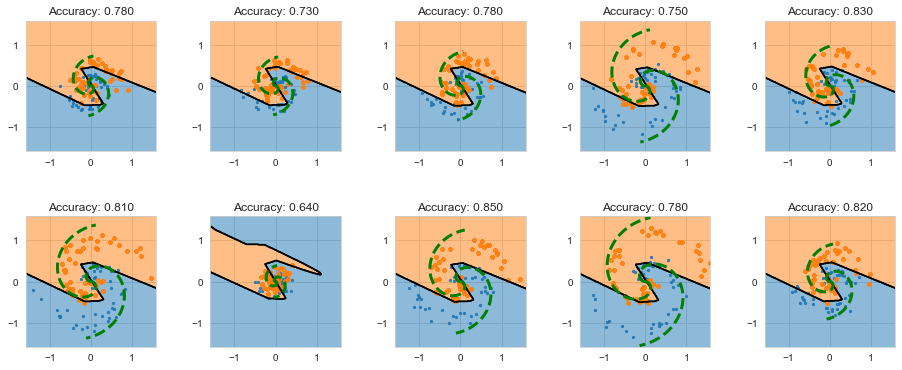

Mean
Accuracy         0.762444
Test Accuracy    0.777000
dtype: float64
95CI low
Accuracy        NaN
Test Accuracy   NaN
dtype: float64
95CI high
Accuracy        NaN
Test Accuracy   NaN
dtype: float64


C:\Users\AndrejTschalzev\AppData\Local\Temp\ipykernel_524\553910355.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figDBME.show()
C:\Users\AndrejTschalzev\AppData\Local\Temp\ipykernel_524\553910355.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figGradsME.show()


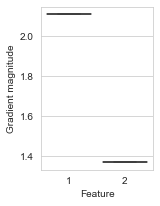

In [41]:
dictBuild = {'n_features': arrX.shape[1],
             'n_clusters': dictSpiralParams['clusters'],
             'adversary_layer_units': [4, 4],
             'slope_posterior_init_scale': 0.3, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.3, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.00001}
dictCompile = {'loss_class_fe_weight': 1.0, 
               'loss_gen_weight': 0.5, 
               'loss_class_me_weight': 1.0,
               'metric_class_me': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_class_fe': tf.keras.metrics.BinaryAccuracy('acc_fe'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsME, dfGradsME, dfRandomSlopeSD, dfRandomIntercept, figDBME = cross_validate(MixedEffectsMLPNonlinearSlope,  
                                                                            use_z=True, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)
figDBME.savefig(os.path.join(strOutputDir, 'mixedeffects_decision_boundaries.png'))
figDBME.savefig(os.path.join(strOutputDir, 'mixedeffects_decision_boundaries.svg'))
figDBME.show()

figGradsME, axGradsME = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsME, x='Feature', y='Gradient', ax=axGradsME, color='C0')
axGradsME.set_ylabel('Gradient magnitude')
figGradsME.savefig(os.path.join(strOutputDir, 'mixedeffects_feature_gradients.png'))
figGradsME.savefig(os.path.join(strOutputDir, 'mixedeffects_feature_gradients.svg'))
figGradsME.show()

compute_95ci(dfResultsME)

## Mixed effects MLP

With domain adversarial loss disabled.

Mean
Accuracy         0.793528
Test Accuracy    0.793262
dtype: float64
95CI low
Accuracy         0.771184
Test Accuracy    0.768500
dtype: float64
95CI high
Accuracy         0.815872
Test Accuracy    0.818023
dtype: float64


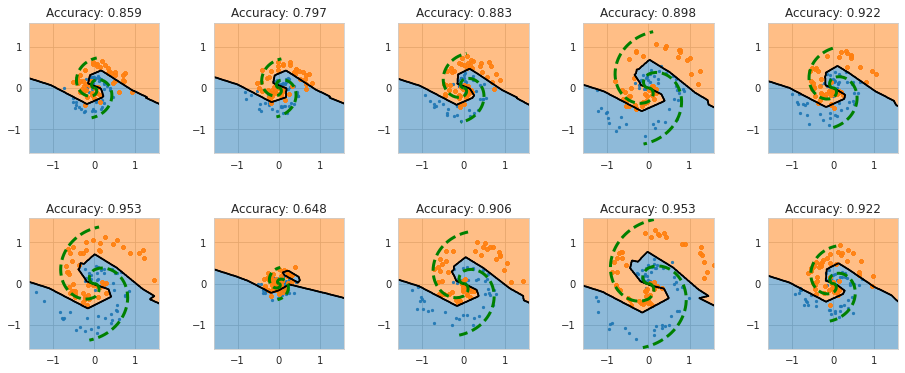

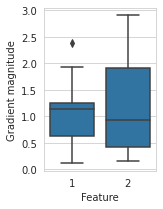

In [13]:
dictBuild = {'n_features': arrX.shape[1],
             'n_clusters': dictSpiralParams['clusters'],
             'adversary_layer_units': [4, 4],
             'slope_posterior_init_scale': 0.3, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.3, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.00001}
dictCompile = {'loss_class_fe_weight': 0., 
               'loss_gen_weight': 0., 
               'loss_class_me_weight': 1.0,
               'metric_class_me': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_class_fe': tf.keras.metrics.BinaryAccuracy('acc_fe'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsME2, dfGradsME2, dfRandomSlopeSD2, dfRandomIntercept2, figDBME2 = cross_validate(MixedEffectsMLPNonlinearSlope,  
                                                                            use_z=True, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile)
figDBME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_decision_boundaries.png'))
figDBME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_decision_boundaries.svg'))
figDBME2.show()

figGradsME2, axGradsME2 = plt.subplots(figsize=(arrX.shape[1], 3))
sns.boxplot(data=dfGradsME2, x='Feature', y='Gradient', ax=axGradsME2, color='C0')
axGradsME2.set_ylabel('Gradient magnitude')
figGradsME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_feature_gradients.png'))
figGradsME2.savefig(os.path.join(strOutputDir, 'mixedeffects_noadv_feature_gradients.svg'))
figGradsME2.show()

compute_95ci(dfResultsME2)

## Mixed effects MLP

With Z input randomized to ablate learned RE information.

2022-02-04 12:43:57.401426: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-04 12:44:00.006965: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Mean
Accuracy         0.785816
Test Accuracy    0.766992
dtype: float64
95CI low
Accuracy         0.779762
Test Accuracy    0.756388
dtype: float64
95CI high
Accuracy         0.791869
Test Accuracy    0.777596
dtype: float64


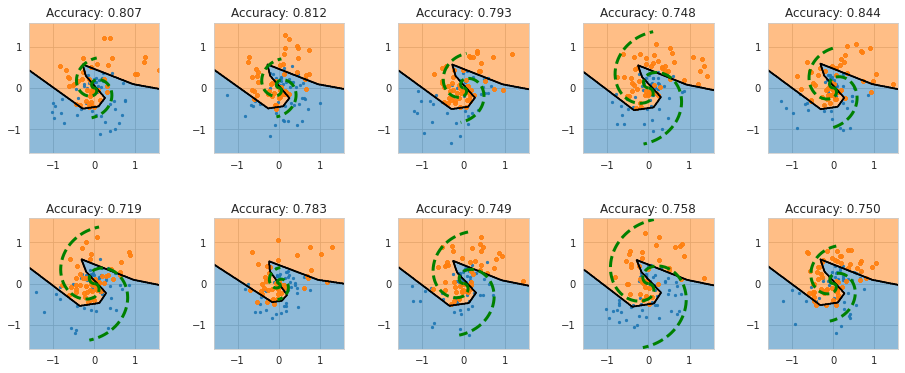

In [8]:
dictBuild = {'n_features': arrX.shape[1],
             'n_clusters': dictSpiralParams['clusters'],
             'adversary_layer_units': [4, 4],
             'slope_posterior_init_scale': 0.3, 
             'intercept_posterior_init_scale': 0.1, 
             'slope_prior_scale': 0.3, 
             'intercept_prior_scale': 0.1,
             'kl_weight': 0.00001}
dictCompile = {'loss_class_fe_weight': 1.0, 
               'loss_gen_weight': 0.5, 
               'loss_class_me_weight': 1.0,
               'metric_class_me': tf.keras.metrics.BinaryAccuracy('acc'),
               'metric_class_fe': tf.keras.metrics.BinaryAccuracy('acc_fe'),
               'metric_adv': tf.keras.metrics.CategoricalAccuracy('adv_acc')}
dfResultsMERandomizedZ, dfGradsMERandomizedZ, dfRandomSlopeSD, dfRandomIntercept, figDBMERandomizedZ = cross_validate(MixedEffectsMLPNonlinearSlope,  
                                                                            use_z=True, 
                                                                            build_args=dictBuild, 
                                                                            compile_args=dictCompile,
                                                                            randomize_z=True)
figDBMERandomizedZ.show()

compute_95ci(dfResultsMERandomizedZ)

Create barplot comparing performance

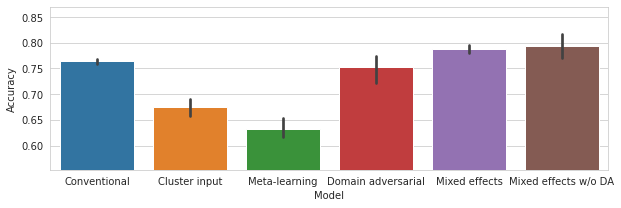

In [14]:
lsPerformance = []
for strModel, df in {'Conventional': dfResultsBase,
                     'Cluster input': dfResultsConcat,
                     'Meta-learning': dfResultsMLDG,
                     'Domain adversarial': dfResultsDA,
                     'Mixed effects': dfResultsME,
                     'Mixed effects w/o DA': dfResultsME2}.items():
    dfLong = df['Test Accuracy'].to_frame('Accuracy')
    dfLong['Model'] = strModel
    lsPerformance += [dfLong]
    
dfPerformance = pd.concat(lsPerformance, axis=0)
figPerf, axPerf = plt.subplots(figsize=(10, 3))
sns.barplot(data=dfPerformance, x='Model',  y='Accuracy', ax=axPerf)
axPerf.set_ylim(dfPerformance['Accuracy'].min() - 0.05, dfPerformance['Accuracy'].max())

figPerf.savefig(os.path.join(strOutputDir, 'performance_comparison.png'))
figPerf.savefig(os.path.join(strOutputDir, 'performance_comparison.svg'))
figPerf.show()

dfPerformance.to_csv(os.path.join(strOutputDir, 'test_performance.csv'))

For the ME-MLP, compare each cluster's learned random intercept with its class balance. When simulating a confounding effect, these two measurements should be highly correlated.

/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


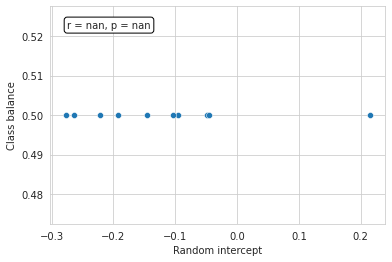

In [15]:
# Compute conversion % by site
dfRatio = pd.DataFrame({'Cluster': arrZ.argmax(axis=1), 'Class': arrY})
dfClusterRatio = dfRatio.groupby('Cluster').mean()
dfClusterRatio.columns = ['Class balance']

dfClusterInt = dfClusterRatio.join(dfRandomIntercept.groupby('Cluster').median())
fig, ax = plt.subplots()
sns.scatterplot(data=dfClusterInt, x='Random intercept', y='Class balance', ax=ax)
r, p = stats.pearsonr(dfClusterInt['Random intercept'], dfClusterInt['Class balance'])
ax.text(0.05, 0.9, f'r = {r:.03f}, p = {p:.2e}', 
        transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'white', 'edgecolor': 'k'})

fig.savefig(os.path.join(strOutputDir, 'mixedeffects_random_intercepts.png'))
fig.savefig(os.path.join(strOutputDir, 'mixedeffects_random_intercepts.svg'))

Compare feature importance.

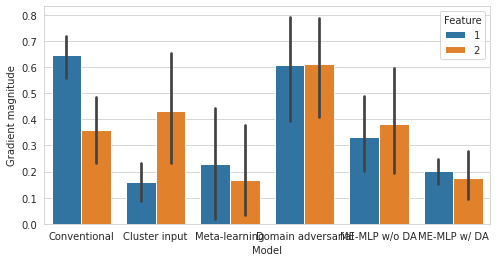

In [16]:
dfGradsBaseNorm = dfGradsBase.copy()
dfGradsBaseNorm['Gradient'] /= dfGradsBaseNorm['Gradient'].max()
dfGradsBaseNorm['Gradient'] -= dfGradsBaseNorm['Gradient'].min()
dfGradsBaseNorm['Model'] = 'Conventional'

dfGradsConcatNorm = dfGradsConcat.copy()
dfGradsConcatNorm['Gradient'] /= dfGradsConcatNorm['Gradient'].max()
dfGradsConcatNorm['Gradient'] -= dfGradsConcatNorm['Gradient'].min()
dfGradsConcatNorm['Model'] = 'Cluster input'

dfGradsMLDGNorm = dfGradsMLDG.copy()
dfGradsMLDGNorm['Gradient'] /= dfGradsMLDGNorm['Gradient'].max()
dfGradsMLDGNorm['Gradient'] -= dfGradsMLDGNorm['Gradient'].min()
dfGradsMLDGNorm['Model'] = 'Meta-learning'

dfGradsDANorm = dfGradsDA.copy()
dfGradsDANorm['Gradient'] /= dfGradsDANorm['Gradient'].max()
dfGradsDANorm['Gradient'] -= dfGradsDANorm['Gradient'].min()
dfGradsDANorm['Model'] = 'Domain adversarial'

dfGradsMENorm = dfGradsME.copy()
dfGradsMENorm['Gradient'] /= dfGradsMENorm['Gradient'].max()
dfGradsMENorm['Gradient'] -= dfGradsMENorm['Gradient'].min()
dfGradsMENorm['Model'] = 'ME-MLP w/ DA'

dfGradsME2Norm = dfGradsME2.copy()
dfGradsME2Norm['Gradient'] /= dfGradsME2Norm['Gradient'].max()
dfGradsME2Norm['Gradient'] -= dfGradsME2Norm['Gradient'].min()
dfGradsME2Norm['Model'] = 'ME-MLP w/o DA'

dfGradsAll = pd.concat([dfGradsBaseNorm, dfGradsConcatNorm, dfGradsMLDGNorm, dfGradsDANorm, dfGradsME2Norm, dfGradsMENorm], axis=0)
figGradsAll, axGradsAll = plt.subplots(figsize=(4 * arrX.shape[1], 4))
sns.barplot(data=dfGradsAll, x='Model', y='Gradient', hue='Feature', ax=axGradsAll)
axGradsAll.set_ylabel('Gradient magnitude')

figGradsAll.savefig(os.path.join(strOutputDir, 'feature_gradients_compared.png'))
figGradsAll.savefig(os.path.join(strOutputDir, 'feature_gradients_compared.svg'))
figGradsAll.show()


When simulating confounds: Test for difference in gradient magnitude between the least important "real" feature and each probe feature

In [17]:
if dictSpiralParams['confounded_vars'] > 0:
    for strModel, df in [('Conventional', dfGradsBase), ('Cluster input', dfGradsConcat), 
                        ('Meta-learning', dfGradsMLDG), ('Domain adversarial', dfGradsDA),
                        ('ME-MLP w/ DA', dfGradsME),
                        ('ME-MLP w/o DA', dfGradsME2)]:
        print(strModel)
        dfRealFeatures = df.loc[df['Feature'].isin(['1', '2'])]
        strRefFeature = dfRealFeatures.groupby('Feature').mean().idxmin().values[0]
        
        for iProbe in range(dictSpiralParams['confounded_vars']):    
            t, p = stats.ttest_rel(df.loc[df['Feature'] == strRefFeature, 'Gradient'],
                                df.loc[df['Feature'] == f'Probe {iProbe + 1}', 'Gradient'])
            print(f'Feature {strRefFeature} vs. Probe {iProbe + 1}: t = {t:.03f}, p = {p:.05f}')